### Learn a differential equation 

* $f(x) = \frac{dx}{dt}$

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable 
import torch.nn.functional as F

%matplotlib inline 

### Set up the data: 

We want to set up a system where the network takes in some random vector $\mathbf{z}$ with the initial $t$ values  and learns the $x$ s.t. that $x$ is the solution to $f(x)=\frac{dx}{dt}$

* $\frac{dx}{dt} = 2x$
* Solution: $x(t) = Ce^{2t}$

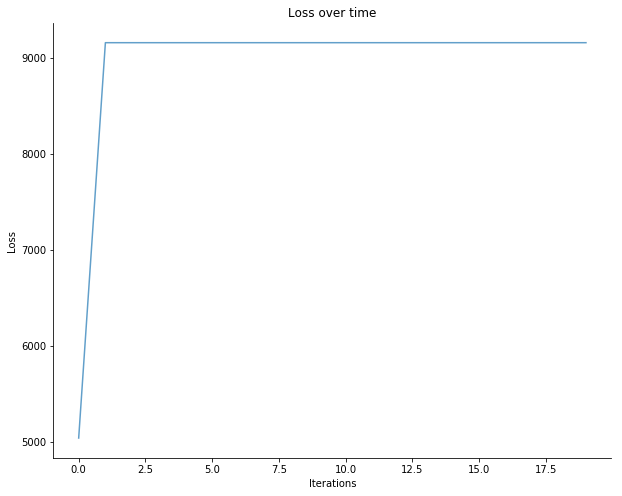

In [120]:
class XLin(nn.Module):
    """ Generative model for the X values s.t. they solve dx/dt = f(x) """
    def __init__(self):
        super(XLin,self).__init__()
        self.lin1 = nn.Linear(1,100)
        self.lin2 = nn.Linear(100,20)
        self.lin3 = nn.Linear(20,10)
        self.lin4 = nn.Linear(10,1)
        
    def forward(self,t):
        var = F.relu(self.lin1(t))
        var = F.relu(self.lin2(var))
        var = F.relu(self.lin3(var))
        x = F.relu(self.lin4(var))
        return x

    
def dxdt(x,t):
    """ Use a 1D conv to take the partial derivative dx/dt """
    var_x = x.view(1,1,-1)
    var_t = t.view(1,1,-1)
    weights = Variable(torch.Tensor([1,-1]).view(1,1,-1),requires_grad=False)
    deriv = torch.div(F.conv1d(var_x,weights), F.conv1d(var_t,weights))
    last_elm = (var_x[:,:,-2]-var_x[:,:,-1])/(var_t[:,:,-2]-var_t[:,:,-1])
    total_deriv = torch.cat([deriv,last_elm.view(1,1,-1)],dim=2)
    return total_deriv.view(-1,1)

def train(net, opt, loss_func, t_in, f, epochs=10, bs=64, use_cuda=False):
    """ Train the model """
    losses,itr = [],0
    big_lam = 100000
    t_first = t_in.ravel()[0]
    nbatches = int(len(t_in)/bs)
    if use_cuda:
        t_tensor = Variable(torch.Tensor(t_in).cuda(),requires_grad=True) 
    else:
        t_tensor = Variable(torch.Tensor(t_in),requires_grad=True) 
        
    for e in range(epochs):
        opt.zero_grad()

        x_est = net(t_tensor)
        fx_est = dxdt(x_est,t_tensor)
        
        x_est_copy = x_est.clone()
        x_est_copy[0] = np.exp(2.0*t_first)
#         print(t_first, np.exp(2.0*t_first))
#         print(x_est_copy)
        fx_true = Variable(f(x_est_copy.data).cuda()) if use_cuda else Variable(f(x_est_copy.data))
#             print('x',t_batch.data.numpy().T,'\nx2',x_est.data.numpy().T)
#             print('est2x',fx_est.data.numpy().T,'\n2x',fx_true.data.numpy().T)
#             print(fx_est.data.numpy().T-fx_true.data.numpy().T)
#         print(energy(fx_true,fx_est,x_est))
#         print((fx_est-fx_true).data.numpy().ravel())
        assert(big_lam*torch.pow(x_est[0]-np.exp(2.0*t_first),2).data.numpy()[0]>=0)
        assert(big_lam*torch.pow(fx_est[0]-f(np.exp(2.0*t_first)),2).data.numpy()[0]>=0)
        assert(big_lam*torch.pow(energy(fx_true,fx_est,x_est),2).data.numpy()[0]>=0)
        loss = loss_func(fx_est, fx_true) + big_lam*torch.pow(x_est[0]-np.exp(2.0*t_first),2) \
                                          + big_lam*torch.pow(fx_est[0]-f(np.exp(2.0*t_first)),2)  \
                                          + big_lam*torch.pow(energy(fx_true,fx_est,x_est),2)
        loss.backward()
        opt.step()

        itr+=1
        losses.append(loss)
            
    losses = [i.data.cpu().numpy()[0] for i in losses] if use_cuda else [i.data.numpy()[0] for i in losses]
    return range(itr),losses
            

use_cuda = torch.cuda.is_available()

np.random.seed(42)
f = lambda x: 2.0*x

# Params
n_examples = 1000

# Set up the data 
t = np.linspace(-1,1,n_examples).reshape(-1,1,1)

# Set up model      
net = XLin().cuda() if use_cuda else XLin()
opt = optim.SGD(net.parameters(),lr=1e-3,weight_decay=0.0)
loss_func = nn.MSELoss()

# Train the model 
itr, losses = train(net, opt, loss_func, t, f, epochs=20, use_cuda=use_cuda)

# Look at plot of loss 
plt.figure(figsize=(10,8))
plt.plot(itr,losses,alpha=0.7)
plt.title('Loss over time')
plt.ylabel('Loss')
plt.xlabel('Iterations')
sns.despine()

In [121]:
t_ex = t[88:91]
learned_x = net(Variable(torch.Tensor(t_ex)))
learned_dxdt = dxdt(learned_x,Variable(torch.Tensor(t_ex)))
analytic_x = np.exp(2.0*t_ex)
analytic_fx = 2.0*learned_x.data.numpy()

print(f'Learned x: {learned_x.data.numpy().ravel()}')
print(f'Analytic x: {analytic_x.ravel()}','\n')

print(f'Learned f(x): {learned_dxdt.data.numpy().ravel()}')
print(f'Analytic f(x): {analytic_fx.ravel()}')

Learned x: [ 0.  0.  0.]
Analytic x: [ 0.19250221  0.19327453  0.19404996] 

Learned f(x): [-0. -0. -0.]
Analytic f(x): [ 0.  0.  0.]


In [ ]:
def energy(fx,dx,x):
    var_fx = fx.view(1,1,-1)
    var_dx = dx.view(1,1,-1)
    var_x = x.view(1,1,-1)
    weights = Variable(torch.Tensor([1,-1]).view(1,1,-1),requires_grad=False)
    var_total = var_dx*var_x
    loss_val = torch.sum(torch.pow(F.conv1d(var_total,weights),2))
    return torch.sum(torch.pow(var_total,2))

### How should we set up the x and t relationship?

It doesn't look like there is much of a signal, but that can be mispecification or just me not doing the right stuff. 

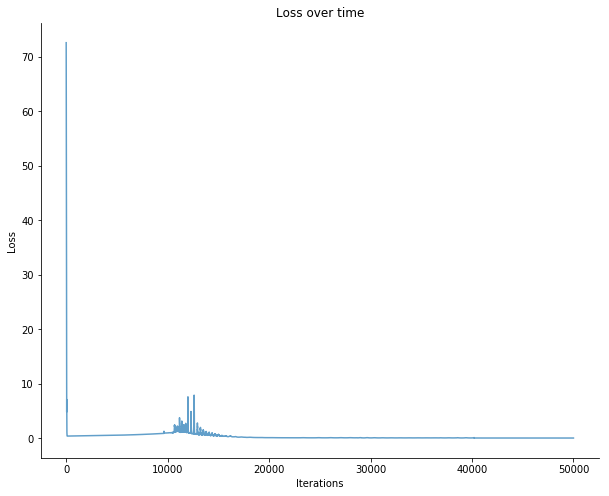

In [184]:
class XGen(nn.Module):
    """ Generative model for the X values s.t. they solve dx/dt = f(x) """
    def __init__(self, indim):
        super(XGen,self).__init__()
        self.deconv1 = nn.ConvTranspose1d(1,10,kernel_size=1)
        self.deconv2 = nn.ConvTranspose1d(10,10,kernel_size=2)
        self.deconv3 = nn.ConvTranspose1d(10,20,kernel_size=2)
        self.linear = nn.Linear(20*(indim+2),1)
        
    def forward(self,t):
        var = F.leaky_relu(self.deconv1(t),0.05)
        var = F.leaky_relu(self.deconv2(var),0.05)
        var = F.leaky_relu(self.deconv3(var),0.05)
        x = self.linear(var.view(var.size(0),-1))
        return x
    
class Analytic(nn.Module):
    """ Generative model for the X values s.t. they solve dx/dt = f(x) """
    def __init__(self, indim):
        super(Analytic,self).__init__()
        self.linear3 = nn.Linear(10,1)
        
    def forward(self,t):
        x = torch.exp(2.0*t)
        return x
    
    
def dxdt(x,t):
    """ Use a 1D conv to take the partial derivative dx/dt """
    var_x = x.view(1,1,-1)
    var_t = t.view(1,1,-1)
    weights = Variable(torch.Tensor([-1,1]).view(1,1,-1),requires_grad=False)
    
    deriv = torch.div(F.conv1d(var_x,weights), F.conv1d(var_t,weights))
    
    last_elm = (var_x[:,:,-2]-var_x[:,:,-1])/(var_t[:,:,-2]-var_t[:,:,-1])
    total_deriv = torch.cat([deriv,last_elm.view(1,1,-1)],dim=2)
    return total_deriv.view(-1,1)
    
def train(net, opt, loss_func, t_in, f, epochs=10, bs=64, use_cuda=False):
    """ Train the model """
    losses,itr = [],0
    big_lam = 1000
    t_first = t_in.ravel()[0]
    nbatches = int(len(t_in)/bs)
    if use_cuda:
        t_tensor = Variable(torch.Tensor(t_in).cuda(),requires_grad=True) 
    else:
        t_tensor = Variable(torch.Tensor(t_in),requires_grad=True) 
        
    for e in range(epochs):
        opt.zero_grad()

        x_est = net(t_tensor)
        fx_est = dxdt(x_est,t_tensor)
        
        x_est_copy = x_est.clone()
        x_est_copy[0] = np.exp(2.0*t_first)

        fx_true = Variable(f(x_est_copy.data).cuda()) if use_cuda else Variable(f(x_est_copy.data))

        assert(big_lam*torch.pow(x_est[0]-np.exp(2.0*t_first),2).data.numpy()[0]>=0)
        assert(big_lam*torch.pow(fx_est[0]-f(np.exp(2.0*t_first)),2).data.numpy()[0]>=0)
        assert(big_lam*torch.pow(energy(fx_true,fx_est,x_est),2).data.numpy()[0]>=0)
        loss = loss_func(fx_est, fx_true) + big_lam*torch.pow(x_est[0]-np.exp(2.0*t_first),2) \
                                          + big_lam*torch.pow(fx_est[0]-f(np.exp(2.0*t_first)),2) 
#                                           + big_lam*torch.pow(energy(fx_true,fx_est,x_est),2)
        loss.backward()
        opt.step()

        itr+=1
        losses.append(loss)
            
    losses = [i.data.cpu().numpy()[0] for i in losses] if use_cuda else [i.data.numpy()[0] for i in losses]
    return range(itr),losses
            

use_cuda = torch.cuda.is_available()

np.random.seed(42)
f = lambda x: 2.0*x

# Params
n_examples = 100

# Set up the data 
t = np.linspace(-1,1,n_examples).reshape(-1,1,1)

# Set up model      
# net = Analytic(1).cuda() if use_cuda else Analytic(1)
net = XGen(1).cuda() if use_cuda else XGen(1)
opt = optim.SGD(net.parameters(),lr=1e-4,weight_decay=0.01)
loss_func = nn.MSELoss()

# Train the model 
itr, losses = train(net, opt, loss_func, t, f, epochs=50000, use_cuda=use_cuda)

# Look at plot of loss 
plt.figure(figsize=(10,8))
plt.plot(itr,losses,alpha=0.7)
plt.title('Loss over time')
plt.ylabel('Loss')
plt.xlabel('Iterations')
sns.despine()

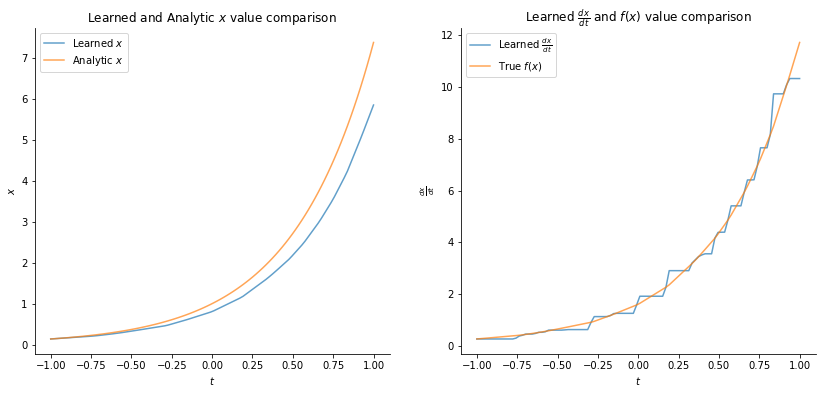

In [202]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))

# Plot X 
ax1.plot(t_ex.ravel(), learned_x.data.numpy().ravel(), alpha=0.7, label=r'Learned $x$')
ax1.plot(t_ex.ravel(), analytic_x.ravel(), alpha=0.7, label=r'Analytic $x$')
ax1.set_title(r'Learned and Analytic $x$ value comparison')
ax1.set_xlabel(r'$t$')
ax1.set_ylabel(r'$x$')
ax1.legend()

# Plot dx/dt and f(x) where x is the learned value
ax2.plot(t_ex.ravel(), learned_dxdt.data.numpy().ravel(), alpha=0.7,label=r'Learned $\frac{dx}{dt}$')
ax2.plot(t_ex.ravel(), analytic_fx.ravel(), alpha=0.7,label=r'True $f(x)$')
ax2.set_title(r'Learned $\frac{dx}{dt}$ and $f(x)$ value comparison')
ax2.set_xlabel(r'$t$')
ax2.set_ylabel(r'$\frac{dx}{dt}$')
ax2.legend()

sns.despine()

In [ ]:
# Print the values 
t_ex = t
learned_x = net(Variable(torch.Tensor(t_ex)))
learned_dxdt = dxdt(learned_x,Variable(torch.Tensor(t_ex)))
analytic_x = np.exp(2.0*t_ex)
analytic_fx = 2.0*learned_x.data.numpy()
print(f't values: {t_ex.ravel()}\n')

print(f'Learned x: {learned_x.data.numpy().ravel()}')
print(f'Analytic x: {analytic_x.ravel()}','\n')

print(f'Learned f(x): {learned_dxdt.data.numpy().ravel()}')
print(f'Analytic f(x): {analytic_fx.ravel()}')


In [175]:
fx_true = Variable(f(learned_x.data))
print(loss_func(learned_dxdt,fx_true))

Variable containing:
 0.1998
[torch.FloatTensor of size 1]



In [131]:
t = Variable(torch.Tensor(np.arange(2,2.5,.01)))
x = Variable(torch.Tensor(t.data**2))
dxdt(x,t)

Variable containing:
 4.0100
 4.0300
 4.0500
 4.0700
 4.0900
 4.1100
 4.1300
 4.1500
 4.1700
 4.1900
 4.2100
 4.2300
 4.2500
 4.2700
 4.2900
 4.3100
 4.3300
 4.3500
 4.3700
 4.3900
 4.4100
 4.4300
 4.4500
 4.4700
 4.4900
 4.5100
 4.5300
 4.5500
 4.5700
 4.5900
 4.6100
 4.6300
 4.6500
 4.6700
 4.6900
 4.7100
 4.7300
 4.7500
 4.7700
 4.7900
 4.8100
 4.8300
 4.8500
 4.8700
 4.8900
 4.9100
 4.9300
 4.9500
 4.9700
 4.9700
[torch.FloatTensor of size 50x1]

In [137]:
# x,t

In [126]:
var_x = x.view(1,1,-1)
var_t = t.view(1,1,-1)
weights = Variable(torch.Tensor([1,-1]).view(1,1,-1),requires_grad=False)
deriv = torch.div(F.conv1d(var_x,weights), F.conv1d(var_t,weights))
print(F.conv1d(var_x,weights).view(-1))
print(F.conv1d(var_t,weights).view(-1))
last_elm = (var_x[:,:,-2]-var_x[:,:,-1])/(var_t[:,:,-2]-var_t[:,:,-1])
total_deriv = torch.cat([deriv,last_elm.view(1,1,-1)],dim=2)

Variable containing:
-0.2100
-0.2300
-0.2500
-0.2700
-0.2900
-0.3100
-0.3300
-0.3500
-0.3700
-0.3900
-0.4100
-0.4300
-0.4500
-0.4700
-0.4900
-0.5100
-0.5300
-0.5500
-0.5700
-0.5900
-0.6100
-0.6300
-0.6500
-0.6700
-0.6900
-0.7100
-0.7300
-0.7500
-0.7700
-0.7900
-0.8100
-0.8300
-0.8500
-0.8700
-0.8900
-0.9100
-0.9300
-0.9500
-0.9700
[torch.FloatTensor of size 39]

Variable containing:
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
-0.1000
[torch.FloatTensor of size 39]

